# Instagram Analysis
Koosha Zarei

Telecom SudParis - September 2018

Libraries:
    - pymongo
    - json
    - re
    - landgetect
    - twitter
    - pd
    - instaloader
    - matplotlib
    - pylab
    
Note:
    first you have to use crawler to capture some data from instagram, and then put the file name here

Instagram is a social media platform for sharing visual media and has become one of the top social networks in recent years. According to Statista, the mainly mobile sharing network, is one of the most popular social networks worldwide and had reached 1 million active users monthly. As a result, it causes advertisement and spam post flooding. The value of detecting and decreasing spams and fake posts are of high importance. In such a scenario, the analysis of comment becomes important for detecting the unusual behaviors and bot patterns.

Comment Json Structure:

    "id": 17971677547123467,
    "created_at": 1539866824,
    "text": "xxxxxxx",
    "owner": {
        "id": "1111111",
        "profile_pic_url": "url",
        "username": "leighblantaco"
    }


In [1]:
#Import all libraries that are required
%matplotlib inline

import numpy as np
import pandas as pd
# pd.options.display.float_formatrmat = '${:,.2f}'.format
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from io import BytesIO
from requests import get
from PIL import Image, ImageDraw
import instaloader
import pymongo

from pandas.io.json import json_normalize
import json

#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*
from itertools import dropwhile, takewhile
import collections

from pandas.tools.plotting import scatter_matrix

## Parameters

In [2]:
# create loader object
L = instaloader.Instaloader()

#Set PANDAS to show all columns in DataFrame
# pd.set_option('display.max_columns', None)
# plt.rcParams['figure.figsize'] = (15, 5)

UTC_FILE_NAME = "_UTC"
COMMENTS_FILE_NAME = "_comments"
FILE_ADDRESS_NAME = "InstagramLog/"


DONALD_TRUMP = 'realdonaldtrump'
DONALD_TRUMP_NAME = 'President Donald J. Trump'
DONALD_TRUMP_BIO = '45th President of the United States'
DONALD_TRUMP_COLOR = '#446fc4'

BARAK_OBAMA = 'barackobama'
BARACK_OBAMA_NAME = 'Barack Obama'
BARACK_OBAMA_BIO = 'Dad, husband, President, citizen.'
BARACK_OBAMA_COLOR = '#7f2d9b'

EMMANUEL_MACRON = 'emmanuelmacron'
EMMANUEL_MACRON_NAME = 'Emmanuel Macron'
EMMANUEL_MACRON_BIO = 'Président de la République française.'
EMMANUEL_MACRON_COLOR = '#369b4f'

USER_ACCOUNT = BARAK_OBAMA
USER_ACCOUNT_NAME = BARACK_OBAMA_NAME
USER_ACCOUNT_BIO = BARACK_OBAMA_BIO


# MongoDB Database
instagramClient = pymongo.MongoClient('157.159.68.107:27017',username='koosha',password='1123581321',authSource='Instagram')
instagram_db = instagramClient["Instagram"]
instagram_col_post = instagram_db["Post"]
instagram_col_comment = instagram_db["Comment"]
instagram_col_like = instagram_db["Like"]
instagram_col_analyse = instagram_db["Analyse"]
instagram_col_mentioned_in_comment = instagram_db["MentionedInComment"]


# Functions

In [3]:
def comment_to_dataframe(json_data):
    
    """
    Load and convert jason file to panda dataframe. Stil there are some bugs. To fix Soon...
    """

    try: 
        with open(json_data, 'r') as f:
            data = json.load(f)

    except EnvironmentError:
        print('No such a file!')
        return
        
#     sanitized = json.loads(json_util.dumps(mongo_data))
    normalized = json_normalize(data)
    df = pd.DataFrame(normalized)
    return df

In [4]:
def find_user_in_text(_text):
    email = re.compile('@\w+')
    listt = email.findall(_text)
    if(len(listt) > 0):
        return [s.replace('@', '') for s in listt]
    else:
        return False

# Calculate Each Post

In [5]:
def initialize_json_data(_shortcode = "" ):
    
    #post = instagram_col_analyse.find_one({'shortcode': _shortcode})

    data = {
        "shortcode" : _shortcode,
        "shortcode_username": USER_ACCOUNT,
        "post_caption": "",

        "total_followers_users_online" : 0,
        "total_followees_users_online" : 0,
        "total_posts_online" : 0,

        "number_of_comments": 0,
        "number_of_likes": 0,
        
        "number_of_unique_user_id_posting_comment": 0,

        "total_amount_of_replies": 0,
        "number_of_unique_extracted_user_in_replies": 0,
        

    }

    #instagram_col_analyse.insert_one(data)
    instagram_col_analyse.update_one( { "shortcode" : _shortcode }, {"$set": data}, upsert=True);

In [6]:
def claculate_number_of_comment(_shortcode=""):
    
    
    number_of_total_comments = len(list(instagram_col_comment.find(
        {
            "$and":
            [ 
                { 'post_shortcode': _shortcode }, 
                { 'shortcode_username': USER_ACCOUNT },
            ]
        }
    )))

    myquery = { 'shortcode': _shortcode }
    newvalues = { "$set": { "number_of_comments": number_of_total_comments } }

    instagram_col_analyse.update_one(myquery, newvalues)



In [7]:
def claculate_number_of_likes(_shortcode=""):
    
    number_of_total_likes = len(list(instagram_col_like.find(
        {
            "$and":
            [ 
                { 'post_shortcode': _shortcode }, 
                { 'shortcode_username': USER_ACCOUNT },
            ]
        }
    
    )))

    myquery = { 'shortcode': _shortcode }
    newvalues = { "$set": { "number_of_likes": number_of_total_likes } }

    instagram_col_analyse.update_one(myquery, newvalues)
    


In [8]:
def claculate_post_profile(_shortcode=""):
    
    post = instagram_col_post.find_one({'shortcode': _shortcode})

    myquery = { 'shortcode': _shortcode }
    newvalues = { "$set": { "post_caption": post['caption'],
                          "total_followers_users_online": post['owner_followers'],
                          "total_followees_users_online": post['owner_followees'],
                          "total_posts_online": post['owner_mediacount'],
                          } }

    instagram_col_analyse.update_one(myquery, newvalues)
    

In [9]:
def check_user_exist(_shortcode, _collection ):
    
    userlist = _collection

    try :
        for username in userlist.copy():
            
            profile = Profile.from_username(L.context, username)
            query = instagram_col_mentioned_in_comment.find_one(
                
                {
                    "$and":
                    [ 
                        { 'post_shortcode': _shortcode }, 
                        { 'id': profile.userid },
                    ]
                }
#                 {'post_shortcode':_shortcode, 'id': profile.userid}          
            )

            if query is None:
                data = {
                    "post_shortcode": _shortcode,
                    "id": profile.userid,
                    "username" : profile.username,
                    "number_of_mentioned": userlist[username],
                    "user_crawled" : True,
                    "profile_pic_url": profile.profile_pic_url,
                    "is_private": profile.is_private,
                    "mediacount": profile.is_private,
                    "followers": profile.followers,
                    "followees": profile.followees,
                    "biography": profile.biography,
                    "full_name": profile.full_name,
                    "is_verified": profile.is_verified,
                }

                instagram_col_mentioned_in_comment.insert_one(data)
                
            else:
                myquery = { 'post_shortcode':_shortcode, 'id': profile.userid }
                newvalues = { "$set": { "number_of_mentioned": userlist[username] } }
                instagram_col_mentioned_in_comment.update_one(myquery, newvalues)
                
            userlist.pop(username)

    except ProfileNotExistsException:
        userlist.pop(username)
        check_user_exist(_shortcode, userlist)


In [10]:
def claculate_number_extracted_users_in_comment(_shortcode=""):
    
    posts = list(instagram_col_comment.find(
        {
            "$and":
            [ 
                { 'post_shortcode': _shortcode }, 
                { 'shortcode_username': USER_ACCOUNT },
            ]
        }
    
    ))
    extracted_users = []

    for post in posts:
        comment_text = post["text"]
        t = find_user_in_text(comment_text)
        if (t):
            extracted_users.extend(t)   
    
    
    total_reply = len(extracted_users)
    
    
    # remove user holder name
    while USER_ACCOUNT in extracted_users: extracted_users.remove(USER_ACCOUNT)
    
    extracted_collection = collections.Counter(extracted_users)
    
    myquery = { 'shortcode': _shortcode }
    newvalues = { "$set": { "number_of_unique_extracted_user_in_replies": len(extracted_collection),
                          "total_amount_of_replies": total_reply } }
    instagram_col_analyse.update_one(myquery, newvalues)
    
    #check_user_exist(_shortcode, extracted_collection)


In [11]:
def calculate_number_of_unique_users_sending_comment(_shortcode=""):
    
    d = list((instagram_col_comment.aggregate([
        
        
        { '$match':
         { 
             '$and': [
                 { 'shortcode_username': USER_ACCOUNT },
                 { 'post_shortcode': _shortcode }
             ]
         }
        },
        
#         { '$match':
         
#         },
        
        {'$group':   {
            '_id': {'ownerid': "$owener_id"},
            'count': {'$sum': 1}
            }
        },
    ])))
    
    myquery = { 'shortcode': _shortcode }
    newvalues = { "$set": { "number_of_unique_user_id_posting_comment": len(d) } }
    instagram_col_analyse.update_one(myquery, newvalues)
    


In [16]:
def statistics_for_post(_shortcode=""):
    
    """
    here we show some statistics about Instagram post and comments.
    """

    pd.options.display.float_format = '${:,.2f}'.format
    
    query = instagram_col_analyse.find_one({'shortcode':_shortcode})
    
    print("Statistics for post: " + _shortcode)
    
    profile_followers = query["total_followers_users_online"]
    profile_followees = query["total_followees_users_online"]
    profile_mediacount = query["total_posts_online"]
    
    number_of_posts = 1 #data_jason["data"]["number_of_posts"]
    number_of_total_comments = query["number_of_comments"]
    number_of_total_likes = query["number_of_likes"]
    
    number_of_unique_extracted_users_in_comments = query["number_of_unique_extracted_user_in_replies"]
    number_of_unique_user_id_posting_comment = query["number_of_unique_user_id_posting_comment"]
    number_of_total_replies = query["total_amount_of_replies"]
                
        
    # create dataframe
    d = []    
    d.append(["Total #comments", number_of_total_comments , "-"])
    d.append(["Total #likes", "{:,}".format(number_of_total_likes) , "-"])

    d.append(["Total number of unique user id posting comments", "{:,}".format(number_of_unique_user_id_posting_comment) , "-"])
    d.append(["Total number of replies in comments", "{:,}".format(number_of_total_replies) , "-"])
    
    d.append(["unique #users extracted from comments", "{:,}".format(number_of_unique_extracted_users_in_comments) , "-"])


    
    df = pd.DataFrame(d, columns=["Name", "Instagram", "Twitter"])
    df = df.set_index(['Name'])

    return df


In [17]:
def calculate_everything_for_post(_shortcode=""):
    print("start processing for post: " + str(_shortcode))
    initialize_json_data(_shortcode)
    claculate_number_of_comment(_shortcode)
    claculate_number_of_likes(_shortcode)
    claculate_post_profile(_shortcode)
    claculate_number_extracted_users_in_comment(_shortcode)
    calculate_number_of_unique_users_sending_comment(_shortcode)
    df = statistics_for_post(_shortcode)
    return df


In [18]:
def remove_bulk_analyzes():
    posts = list(instagram_col_post.find({}))
    analyzes = list(instagram_col_analyse.find({}))
    
    list_analyze = []
    for an in analyzes:
        list_analyze.append(an['shortcode'])
        
    
    list_post = []
    for post in posts:
        list_post.append(post['shortcode'])
        
    for i in list_post:
        if (i in list_analyze):
            list_analyze.remove(i)
            
            
    for i in list_analyze:
        instagram_col_analyse.delete_many( { "shortcode" : i } );
    

In [19]:
def analyse_post():
    posts = list(instagram_col_post.find({ 'owner_username': USER_ACCOUNT }))
    for post in posts:
        df = calculate_everything_for_post(post["shortcode"])
        display(df)  # df for each post

# analyse_post()  

# Plot

In [12]:
def statistics_final():
    
    """
    here we show some statistics about Instagram post and comments.
    """

    pd.options.display.float_format = '${:,.2f}'.format
    
    
    posts = instagram_col_post.find({ 'owner_username': USER_ACCOUNT }).count()
    comments = instagram_col_comment.find({ 'shortcode_username': USER_ACCOUNT }).count()
    likes = instagram_col_like.find({ 'shortcode_username': USER_ACCOUNT }).count()
    analyzes = list(instagram_col_analyse.find({ 'shortcode_username': USER_ACCOUNT }))
    
    
    number_of_posts = posts
    number_of_total_comments = comments
    number_of_total_likes = likes
    
    reply_counter = 0
    total_user_extracted_from_comment = 0
        
    for an in analyzes:
        reply_counter += an['total_amount_of_replies']
        total_user_extracted_from_comment += an['number_of_unique_extracted_user_in_replies']
        
    
    total_amount_of_mention_in_comment = reply_counter
    
    # need to change this part
    total_number_of_unique_user_id_in_like = list((instagram_col_like.aggregate(pipeline = [
        
        { '$match':
         { 
             '$and': [
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },     
        
        {'$group':   {
            '_id': {'ownerid': "$owener_id"},
            #'text': {'$addToSet': "$owener_username"},
            'count': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    )))
    
    list_like = []
    for i in total_number_of_unique_user_id_in_like:
        list_like.append(i['_id']['ownerid'])
    

    
    total_number_of_unique_user_id_in_comment = list((instagram_col_comment.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },
        
        {'$group':   {
            '_id': {'ownerid': "$owener_id"},
            #'text': {'$addToSet': "$owener_username"},
            'count': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    )))
    
    
    list_comment = []
    for i in total_number_of_unique_user_id_in_comment:
        list_comment.append(i['_id']['ownerid'])
    
    
    resultList= list(set(list_like)|set(list_comment))
    
    total_number_of_unique_user_id = len(resultList)
    
    
    list_of_unique_user_id_per_comment = list(instagram_col_comment.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },
        
        {'$group':   {
            "_id": "$owener_id",
            "totalComment" : {"$sum" : 1},
            "post_ids" : {"$addToSet" : "$post_shortcode"},
            "post_text" : {"$addToSet" : "$id"},
            }
        },

     
        { '$project':  {
            "numberOf_post_ids" : { "$size": "$post_text" }
         }
        },
    
        {
           '$group':   {
               
            "_id": "$numberOf_post_ids",
            "total" : {"$sum" : 1},

            } 
        }
    

    ],
        allowDiskUse=True
    ))

    total = 0
    summation = 0

    for i in list_of_unique_user_id_per_comment:
        multi = i['_id'] * i['total']
        summation += multi
        total += i['total']

    avg_post_per_unique_user_id = summation / total

    

    
    list_of_unique_user_id_per_like = list(instagram_col_like.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },
        
        {'$group':   {
            "_id": "$owener_id",
            "total_like" : {"$sum" : 1},
            }
        },

        {
           '$group':   {
               
            "_id": "$total_like",
            "count" : {"$sum" : 1},
            "ids": {"$addToSet": "$_id"}

            } 
        }
    
    ],
        allowDiskUse=True
    ))

    total_l = 0
    summation_l = 0

    for j in list_of_unique_user_id_per_like:
        multi_l = j['_id'] * j['count']
        summation_l += multi_l
        total_l += j['count']
    
    avg_like_per_unique_user_id = summation_l / total_l
    
    
    
    # user profile - comment
    user_profile_from_comment = list(instagram_col_comment.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'owener_is_private' : { '$first': '$owener_is_private' },
             'post_shortcode' : { '$first': '$post_shortcode' },
             'count': {'$sum': 1}
            }
        },
    ],
        allowDiskUse=True
    ))

    total_user_followers_in_comment = 0
    total_user_followees_in_comment = 0
    total_user_mediacount_in_comment = 0
    total_user_with_public_account_in_comment = 0
    number_of_user_profile_from_comment = len(user_profile_from_comment)

    for user in user_profile_from_comment:
        if (user['owener_followers'] == ""):
            total_user_followers_in_comment += 0
        else:
            total_user_followers_in_comment += user['owener_followers']
            
        if (user['owener_followees'] == ""):
            total_user_followees_in_comment += 0
        else:
            total_user_followees_in_comment += user['owener_followees']
            
        if (user['owener_mediacount'] == ""):
            total_user_mediacount_in_comment += 0
        else:
            total_user_mediacount_in_comment += user['owener_mediacount']
            
        if (user['owener_is_private'] == False):
            total_user_with_public_account_in_comment += 1

            
            
            
    # user profile - like
    user_profile_from_like = list(instagram_col_like.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'owener_is_private' : { '$first': '$owener_is_private' },
             'post_shortcode' : { '$first': '$post_shortcode' },
             'count': {'$sum': 1}
            }
        },
    ],
        allowDiskUse=True
    ))

    total_user_followers_in_like = 0
    total_user_followees_in_like = 0
    total_user_mediacount_in_like = 0
    total_user_with_public_account_in_like = 0
    number_of_user_profile_from_like = len(user_profile_from_like)


    for user in user_profile_from_like:
        if (user['owener_followers'] == ""):
            total_user_followers_in_like += 0
        else:
            total_user_followers_in_like += user['owener_followers']

        if (user['owener_followees'] == ""):
            total_user_followees_in_like += 0
        else:
            total_user_followees_in_like += user['owener_followees']

        if (user['owener_mediacount'] == ""):
            total_user_mediacount_in_like += 0
        else:
            total_user_mediacount_in_like += user['owener_mediacount']

        if (user['owener_is_private'] == False):
            total_user_with_public_account_in_like += 1
    

    # create dataframe
    d = []    
    d.append(["Total #posts", "{:,}".format(number_of_posts) , "-"])
    d.append(["Total #comments", "{:,}".format(number_of_total_comments) , "-"])
    d.append(["Total #likes", "{:,}".format(number_of_total_likes) , "-"])
    d.append(["Total #mentions", "{:,}".format(total_amount_of_mention_in_comment) , "-"])
    
    
    d.append(["avg #comments per post", "{:,.0f}".format(number_of_total_comments/number_of_posts ) , "-"])
    d.append(["avg #likes per post", "{:,.0f}".format(number_of_total_likes/ number_of_posts) , "-"])
    d.append(["avg #mention per post", "{:,.0f}".format(total_amount_of_mention_in_comment/ number_of_posts) , "-"])
    
    d.append(["avg #replies per post", "-" , "-"])
    d.append(["-", "-" , "-"])
    
    
    d.append(["unique #users mentioned in comments", "{:,}".format(total_user_extracted_from_comment) , "-"])
    d.append(["unique #users posting comments", "{:,}".format(len(list_comment)) , "-"])
    d.append(["unique #users extracted from likes", "{:,}".format(len(list_like)) , "-"])
    
    d.append(["total number of unique user id (like + comment)", "{:,}".format(total_number_of_unique_user_id) , "-"])
    d.append(["#users extracted from trump profile", "-" , "-"])
    
    d.append(["-", "-" , "-"])
    
    d.append(["avg #posts per unique user id (comment)", "{:,.2f}".format(avg_post_per_unique_user_id) , "-"])
    d.append(["avg #posts per unique user id (like)", "{:,.2f}".format(avg_like_per_unique_user_id) , "-"])
    d.append(["-", "-" , "-"])
    
    d.append(["avg #followers per unique user id (comment)", "{:,.2f}".format(total_user_followers_in_comment/number_of_user_profile_from_comment) , "-"])
    d.append(["avg #followees per unique user id (comment)", "{:,.2f}".format(total_user_followees_in_comment/number_of_user_profile_from_comment) , "-"])
    d.append(["avg #miadcount per unique user id (comment)", "{:,.2f}".format(total_user_mediacount_in_comment/number_of_user_profile_from_comment) , "-"])
    d.append(["avg #public_account per unique user id (comment)", "{:,.2f}".format(total_user_with_public_account_in_comment/number_of_user_profile_from_comment) , "-"])
    
    d.append(["-", "-" , "-"])
    
    d.append(["avg #followers per unique user id (like)", "{:,.2f}".format(total_user_followers_in_like/number_of_user_profile_from_like) , "-"])
    d.append(["avg #followees per unique user id (like)", "{:,.2f}".format(total_user_followees_in_like/number_of_user_profile_from_like) , "-"])
    d.append(["avg #miadcount per unique user id (like)", "{:,.2f}".format(total_user_mediacount_in_like/number_of_user_profile_from_like) , "-"])
    d.append(["avg #public_account per unique user id (like)", "{:,.2f}".format(total_user_with_public_account_in_like/number_of_user_profile_from_like) , "-"])
    d.append(["-", "-" , "-"])
    
    d.append(["avg #age post per like (tarikhe post)", "{:,}".format(0) , "-"])
    d.append(["avg #age post per comment", "{:,}".format(0) , "-"])
              
    # distribution ha
    # 2d comment like - post - log()
              
    
    df = pd.DataFrame(d, columns=["Name", "Trump Instagram (@realdonaldtrump)", "Trump Twitter (@realdonaldtrump)"])
    df = df.set_index(['Name'])

    return df

statistics_final()

/Users/kooshazarei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/kooshazarei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/kooshazarei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if sys.path[0] == '':


OperationFailure: BSONObj size: 36129143 (0x2274977) is invalid. Size must be between 0 and 16793600(16MB) First element: _id: 1

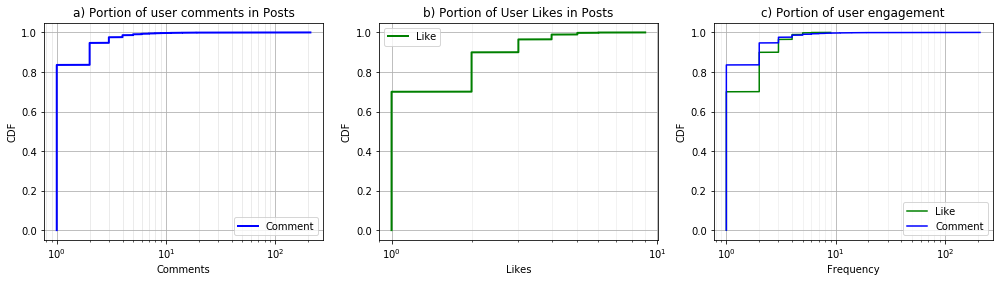

In [20]:
def plot_1():

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,4))
    
    list_of_unique_user_id_per_comment = list(instagram_col_comment.aggregate([
        
        { '$match':
         { 
             '$and': [ 
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        {'$group':   {
            "_id": "$owener_id",
            "totalComment" : {"$sum" : 1},
            }
        },

    ]))
    

    list_of_unique_user_id_per_like = list(instagram_col_like.aggregate(pipeline=[
        
        { '$match':
         { 
             '$and': [ 
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        {'$group':   {
            "_id": "$owener_id",
            "count" : {"$sum" : 1},
            }
        },

    ],
        allowDiskUse=True
    ))
    
    
    data =  pd.DataFrame(list_of_unique_user_id_per_comment)
    ser = data[['totalComment']].copy()
    
    ser = ser.sort_values(by=['totalComment'])
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
#     ser_cdf.index.name = "Comments"    
    ax = ser_cdf.plot( logx=True, grid=True, linewidth=2, legend=True, label='Comment', ax=ax1, color='blue')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.3)
    ax.set_xlabel("Comments")
#     ax.yaxis.grid(True, which='minor', linestyle='-', alpha=0.3)
    ax.set_title("a) Portion of user comments in Posts")
    ax.set_ylabel("CDF")

    
    data2 =  pd.DataFrame(list_of_unique_user_id_per_like)
    ser2 = data2[['count']].copy()
    ser2 = ser2.sort_values(by=['count'])
    ser2[len(ser2)] = ser2.iloc[-1]
    cum_dist2 = np.linspace(0.,1.,len(ser2))
    ser_cdf2 = pd.Series(cum_dist2, index=ser2)
#     ser_cdf2.index.name = "Likes"    
    ax = ser_cdf2.plot( logx=True, grid=True, linewidth=2, legend=True, label='Like', ax=ax2, color='green')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2 )
    ax.set_ylabel("CDF")
    ax.set_xlabel("Likes")
    ax.set_title("b) Portion of User Likes in Posts")


    
    ax = ser_cdf2.plot( logx=True, grid=True, legend=True, label='Like', ax=ax3, color='green')
    ax = ser_cdf.plot( logx=True, grid=True,  legend=True, label='Comment', ax=ax3, color='blue')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2 )
    ax.set_ylabel("CDF")
    ax.set_xlabel("Frequency")
    ax.set_title("c) Portion of user engagement")
plot_1()

For analyzing user reactions, around 3M likes among 40 Instagram posts of Donal Trump in the period of 2 months have been considered and more than 200K comments by unique user ids processed and examined.

Figure a) presents the empirical distribution of comments issued by each unique Instagram account. To explore this, . This amount of comment are collected from more than 30 posts. From the graph it can be seen that near 75% users sent just one comment and the rest of the users are more active in the term of commenting and replying.

Figure b) demonstrates distribution of the like action for Instagram posts taken by each unique account. By analyzing this figure, it is amazing that more than 50% of the whole unique users, are engaged and giving more Like than one time (more active). In the other aspect, approximately 10% of the users are heavily envolved with posts and and gave Like more than 10 times. On average, each unique user, liked 2.7 posts in this period and each post get more than 90K likes by users (follower and non-follower).

In figure c) the comparison between two reactions is demonstrated. It is clear users are more active in the term of liking the post and more than 40% of the users like posts more than one time. In contrast, just 20% of unique accounts prefer to comment more than one time.


In [21]:
def plot_3():
    
    user_profile_from_comment = list(instagram_col_comment.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': DONALD_TRUMP },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    ))

    
    total_user_followers = []
    total_user_followees = []
    total_user_mediacount = []


    for user in user_profile_from_comment:
        if (user['owener_followers'] == "" or user['owener_followees'] == "" or user['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers.append(user['owener_followers'])
            total_user_followees.append(user['owener_followees'])
            total_user_mediacount.append(user['owener_mediacount'])
            

#     fig = plt.figure(figsize=(6,4))
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,4))

    # followers
    data =  pd.DataFrame(total_user_followers)
    data.columns = ['followers']    
    ser = data[['followers']].copy()
    ser = ser.sort_values(by='followers')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Frequency"    
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='D. Trump')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title('a) Followers')
    
    
    
    # followees
    data =  pd.DataFrame(total_user_followees)
    data.columns = ['followees']    
    ser = data[['followees']].copy()
    ser = ser.sort_values(by='followees')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Frequency"    
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='D. Trump')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title("b) Followees")
    
    
    # media count
    data =  pd.DataFrame(total_user_mediacount)
    data.columns = ['owener_mediacount']
    ser = data[['owener_mediacount']].copy()
    ser = ser.sort_values(by='owener_mediacount')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Frequency"    
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='D. Trump' )
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title("c) Media Count")
    
    
    
    user_profile_from_comment = list(instagram_col_comment.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': EMMANUEL_MACRON },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    ))

    
    total_user_followers = []
    total_user_followees = []
    total_user_mediacount = []


    for user in user_profile_from_comment:
        if (user['owener_followers'] == "" or user['owener_followees'] == "" or user['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers.append(user['owener_followers'])
            total_user_followees.append(user['owener_followees'])
            total_user_mediacount.append(user['owener_mediacount'])
            
            
    data =  pd.DataFrame(total_user_followers)
    data.columns = ['followers']    
    ser = data[['followers']].copy()
    ser = ser.sort_values(by='followers')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)  
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='E. Macron')
    
    
    data =  pd.DataFrame(total_user_followees)
    data.columns = ['followees']    
    ser = data[['followees']].copy()
    ser = ser.sort_values(by='followees')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='E. Macron')
    
    # media count
    data =  pd.DataFrame(total_user_mediacount)
    data.columns = ['owener_mediacount']
    ser = data[['owener_mediacount']].copy()
    ser = ser.sort_values(by='owener_mediacount')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='E. Macron' )
    
    
    
    user_profile_from_comment = list(instagram_col_comment.aggregate(pipeline=[

        { '$match':
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': BARAK_OBAMA },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    ))

    
    total_user_followers = []
    total_user_followees = []
    total_user_mediacount = []


    for user in user_profile_from_comment:
        if (user['owener_followers'] == "" or user['owener_followees'] == "" or user['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers.append(user['owener_followers'])
            total_user_followees.append(user['owener_followees'])
            total_user_mediacount.append(user['owener_mediacount'])
            
            
    data =  pd.DataFrame(total_user_followers)
    data.columns = ['followers']    
    ser = data[['followers']].copy()
    ser = ser.sort_values(by='followers')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)  
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='B. Obama')
    
    
    data =  pd.DataFrame(total_user_followees)
    data.columns = ['followees']    
    ser = data[['followees']].copy()
    ser = ser.sort_values(by='followees')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='B. Obama')
    
    # media count
    data =  pd.DataFrame(total_user_mediacount)
    data.columns = ['owener_mediacount']
    ser = data[['owener_mediacount']].copy()
    ser = ser.sort_values(by='owener_mediacount')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='B. Obama' )
    
    
    plt.savefig("cdf_comment_features_all.pdf")

plot_3()

KeyboardInterrupt: 

to explore further and analyze user behavior in depth, in this section, we also analyze the profiles of users. Regarding to Instagram, profiles are divided into two public and private categories. In public ones, all the information is available for everyone. In the contrast, from public profile, some features and useful information including a) username, b) name and family (if available), c) biography, d) number of followers, e) number of followees, f) number of media count, and g) public story can be extracted.

At first, users that are just engaged in sending comment are considered. Figure a) to c) demonstrate the empirical distribution of the number of Followers, Followees, and Media Count of their profile respectively. By comparing them, it is obvious that their distribution is different and among them, Media Count frequency is less aggressive. For example, we see that it’s around 20% for the data having respectively 90, 100, and 10 as values.


In [16]:
def plot_3_2():
    
    user_profile_from_like = list(instagram_col_like.aggregate(pipeline=[

        { '$match':
         
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': DONALD_TRUMP },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    ))

    
    total_user_followers = []
    total_user_followees = []
    total_user_mediacount = []


    for user in user_profile_from_like:
        if (user['owener_followers'] == "" or user['owener_followees'] == "" or user['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers.append(user['owener_followers'])
            total_user_followees.append(user['owener_followees'])
            total_user_mediacount.append(user['owener_mediacount'])

            
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,4))

    # followers
    data =  pd.DataFrame(total_user_followers)
    data.columns = ['followers']    
    ser = data[['followers']].copy()
    ser = ser.sort_values(by='followers')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Frequency"    
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='D. Trump')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title('a) Followers')
    
    
    
    # followees
    data =  pd.DataFrame(total_user_followees)
    data.columns = ['followees']    
    ser = data[['followees']].copy()
    ser = ser.sort_values(by='followees')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Frequency"    
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='D. Trump')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title("b) Followees")
    
    
    # media count
    data =  pd.DataFrame(total_user_mediacount)
    data.columns = ['owener_mediacount']
    ser = data[['owener_mediacount']].copy()
    ser = ser.sort_values(by='owener_mediacount')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Frequency"    
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='D. Trump')
    ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax.set_ylabel("CDF")
    ax.set_title("c) Media Count")
    
    
    
    user_profile_from_like = list(instagram_col_like.aggregate(pipeline=[

        { '$match':
         
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': EMMANUEL_MACRON },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    ))

    
    total_user_followers = []
    total_user_followees = []
    total_user_mediacount = []


    for user in user_profile_from_like:
        if (user['owener_followers'] == "" or user['owener_followees'] == "" or user['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers.append(user['owener_followers'])
            total_user_followees.append(user['owener_followees'])
            total_user_mediacount.append(user['owener_mediacount'])


    # followers
    data =  pd.DataFrame(total_user_followers)
    data.columns = ['followers']    
    ser = data[['followers']].copy()
    ser = ser.sort_values(by='followers')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='E. Macron')
    
    
    
    # followees
    data =  pd.DataFrame(total_user_followees)
    data.columns = ['followees']    
    ser = data[['followees']].copy()
    ser = ser.sort_values(by='followees')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='E. Macron')
    
    
    # media count
    data =  pd.DataFrame(total_user_mediacount)
    data.columns = ['owener_mediacount']
    ser = data[['owener_mediacount']].copy()
    ser = ser.sort_values(by='owener_mediacount')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='E. Macron')
    
    
    
    user_profile_from_like = list(instagram_col_like.aggregate(pipeline=[

        { '$match':
         
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': BARAK_OBAMA },
             ]
         }
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    ))

    
    total_user_followers = []
    total_user_followees = []
    total_user_mediacount = []


    for user in user_profile_from_like:
        if (user['owener_followers'] == "" or user['owener_followees'] == "" or user['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers.append(user['owener_followers'])
            total_user_followees.append(user['owener_followees'])
            total_user_mediacount.append(user['owener_mediacount'])


    # followers
    data =  pd.DataFrame(total_user_followers)
    data.columns = ['followers']    
    ser = data[['followers']].copy()
    ser = ser.sort_values(by='followers')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='B. Obama')
    
    
    
    # followees
    data =  pd.DataFrame(total_user_followees)
    data.columns = ['followees']    
    ser = data[['followees']].copy()
    ser = ser.sort_values(by='followees')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='B. Obama')
    
    
    # media count
    data =  pd.DataFrame(total_user_mediacount)
    data.columns = ['owener_mediacount']
    ser = data[['owener_mediacount']].copy()
    ser = ser.sort_values(by='owener_mediacount')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ax = ser_cdf.plot(drawstyle='steps',logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='B. Obama')
    
    
    plt.savefig("cdf_like_features_all.pdf")

plot_3_2()

Following the above section and investigating user profiles, in these figures, users that are just engaged in making like are examined. Figure a) to c) demonstrate the empirical distribution of the number of Followers, Followees, and Media Count of their profile sequentially. Among 40 posts, more than 200K comments are analyzed and on average, each post gets approximately 4K comments. On the other hand, the total number of individual accounts which are posting a comment in this analysis is around 70K.

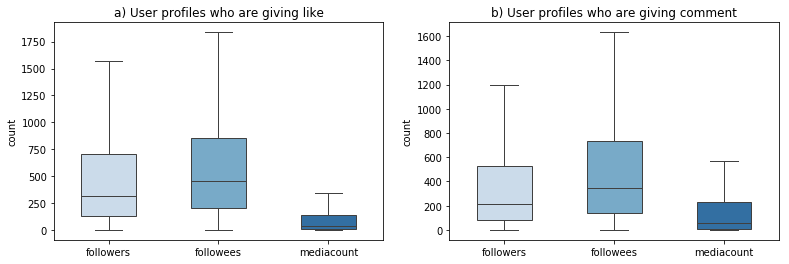

In [20]:
def plot_3_22():
    
    user_profile_from_like = list(instagram_col_like.aggregate(pipeline=[

        { '$match':
         
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': USER_ACCOUNT },
             ] 
         
         }
         
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ],
        allowDiskUse=True
    ))

    
    total_user_followers = []
    total_user_followees = []
    total_user_mediacount = []


    for like in user_profile_from_like:
        if (like['owener_followers'] == "" or like['owener_followees'] == "" or like['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers.append(like['owener_followers'])
            total_user_followees.append(like['owener_followees'])
            total_user_mediacount.append(like['owener_mediacount'])
            
            
            
    user_profile_from_comment = list(instagram_col_comment.aggregate([

        { '$match':
         { 
             '$and': [ 
                 { 'user_crawled': True }, 
                 { 'user_not_exists': None },
                 { 'shortcode_username': USER_ACCOUNT },
             ] 
         
         }
         
        },

        { '$group':   
         {
            '_id': {'ownerid': "$owener_id"},
             'owener_followers' : { '$first': '$owener_followers' },
             'owener_followees' : { '$first': '$owener_followees' },
             'owener_mediacount' : { '$first': '$owener_mediacount' },
             'total': {'$sum': 1}
            }
        },

    ]))

    
    total_user_followers_c = []
    total_user_followees_c = []
    total_user_mediacount_c = []


    for user in user_profile_from_comment:
        if (user['owener_followers'] == "" or user['owener_followees'] == "" or user['owener_mediacount'] == ""):
            continue
        else:
            total_user_followers_c.append(user['owener_followers'])
            total_user_followees_c.append(user['owener_followees'])
            total_user_mediacount_c.append(user['owener_mediacount'])

            
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    data =  pd.DataFrame({'followers' : total_user_followers, 'followees': total_user_followees, 'mediacount': total_user_mediacount})
    data2 =  pd.DataFrame({'followers' : total_user_followers_c, 'followees': total_user_followees_c, 'mediacount': total_user_mediacount_c})
    
    
    s1 = pd.Series(total_user_followers)
    s1.name = 'l followers'
    s2 = pd.Series(total_user_followers_c)
    s2.name = 'c followers'
    
    s3 = pd.Series(total_user_followees)
    s3.name = 'l followees'
    s4 = pd.Series(total_user_followees_c)
    s4.name = 'c followees'
    
    s5 = pd.Series(total_user_mediacount)
    s5.name = 'l mediacount'
    s6 = pd.Series(total_user_mediacount_c)
    s6.name = 'c mediacount'
    
    data3 = pd.concat([s1,s2, s3, s4, s5, s6], axis=1)
#     print(data3)

#     data3 =  pd.DataFrame({'l followers' : total_user_followers, 
#                            'l followees': total_user_followees, 
#                            'l mediacount': total_user_mediacount,
#                            'c followers' : total_user_followers_c, 
#                            'c followees': total_user_followees_c, 
#                            'c mediacount': total_user_mediacount_c})
    
    

    
#     sns.set_style("whitegrid")
    boxplot = sns.boxplot( data=data, showfliers=False, palette="Blues", linewidth=1, width=0.5, ax=ax1)
#     boxplot.set_xlabel("profile of users sending like")
    boxplot.set_ylabel("count")
    boxplot.set_title("a) User profiles who are giving like")

    boxplot2 = sns.boxplot( data=data2, showfliers=False, palette="Blues", linewidth=1, width=0.5, ax=ax2)
#     boxplot2.set_xlabel("profile of users sending comment")
    boxplot2.set_ylabel("count")
    boxplot2.set_title("b) User profiles who are giving comment")
    
    
    fig, (ax3) = plt.subplots(1,1, figsize=(13,5))
#     my_pal = {"l followers": "g", "c followers": "b", "l followees":"m"}
    boxplot3 = sns.boxplot( data=data3, showfliers=False, linewidth=1, width=0.5, ax=ax3)
#     boxplot3.set_xlabel("")
    boxplot3.set_ylabel("count")
    boxplot3.set_title("c) User profile analysis of both groups (like + comment))")
#     boxplot3.set_yscale('log')

        
    mybox = boxplot3.artists[0]
    mybox.set_facecolor('#839bc1')
    
    mybox = boxplot3.artists[1]
    mybox.set_facecolor('#839bc1')
    
    mybox = boxplot3.artists[2]
    mybox.set_facecolor('#5b8bd8')
    
    mybox = boxplot3.artists[3]
    mybox.set_facecolor('#5b8bd8')
    
    mybox = boxplot3.artists[4]
    mybox.set_facecolor('#456dad')
    
    mybox = boxplot3.artists[5]
    mybox.set_facecolor('#456dad')


plot_3_22()

These boxplots compare the main characteristics of user profile regarding their amount of Follower, Followee and Media Count. In the figure a) user profile of users who are giving just like is shown and in figure b) the same information for users giving comment is drown.

The comparison among them can be seen in figure c) which each feature is designated in a separate colour. It can be noticed that the big distinction here is in the quantity of shared-media. For example, 
The unusual pattern here is that while the media shared by group C is larger than group L, but the number of follower and followee of L group is larger.

In [21]:
from scipy.ndimage.filters import gaussian_filter1d

def plot_4():
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    
    df_mean = pd.DataFrame()
    posts = instagram_col_post.find({ "owner_username" : USER_ACCOUNT })
    
    for post in posts:
        post_shortcode = post['shortcode']
        post_time = pd.to_datetime(post['date_utc'], format='%Y-%m-%d %H:%M:%S')
    
        comments = list(instagram_col_comment.find({'post_shortcode': post_shortcode}, { 'created_at': 1 }))

        data =  pd.DataFrame(comments)
        data_new = data[['created_at']].copy()

        data_new['created_at'] = pd.to_datetime(data_new['created_at'], format='%Y-%m-%d %H:%M:%S')
        data_new['period'] = (data_new['created_at'] - post_time).dt.days
    
        data_group = data_new.groupby('period').count().reset_index()
        
        # scatter
        ax = data_group.plot.scatter(x='period', y='created_at', c='blue', alpha=0.1, ax=ax1, logy=True, grid=True, s=22*2)
        ax.grid(True, which='both', linestyle='-', alpha=0.2)
        ax.set_ylabel("Comment Frequency")
        ax.set_xlabel("Age (Day)")
        ax.set_title("a) Comment frequncy vs. age of the comment")
        
        # line
        ax2 = data_group.plot(x='period', y='created_at', c='blue', alpha=0.1, ax=ax2, logy=True, grid=True)
        ax2.get_legend().remove()
        ax2.grid(True, which='both', linestyle='-', alpha=0.2)
        ax2.set_ylabel("Comment Frequency")
        ax2.set_xlabel("Age (Day)")
        ax2.set_title("b) Comment frequncy vs. age of the comment")
        
        data_group = data_group.set_index(['period'])
        df_mean = pd.concat([df_mean, data_group], axis=1)


    # mean line
    df_meann = df_mean.mean(axis=1)
    jj = df_meann.rolling(2).sum()
    ax3 = jj.plot( c='gray', alpha=0.9, ax=ax2, logy=True, grid=True)
    ax3.set_xlabel("Age (Day)")
    ax4 = jj.plot( c='gray', alpha=0.9, ax=ax1, logy=True, grid=True)
    ax4.set_xlabel("Age (Day)")
    
plot_4()

From the other aspect, we investigate the age of comments being generated by the users. Figure a) is the scatter representation of the number of posts versus their age (numbers are demonstrated with the blue circle). 

It can be perceived that in all cases the first day gets the largest number of comments and it reduces as it proceeds. In general, user’s tendency for commenting is in the first 10 to 15 days. Between the period of day 17 to 25, some fluctuations are identified but the general trend is descending. The grey line is giving the average pattern of the dots. Figure b) is the equivalent knowledge with line representation.



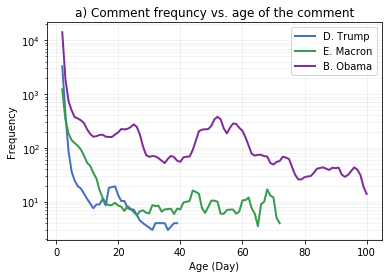

In [40]:
from scipy.ndimage.filters import gaussian_filter1d

def plot_4_1():
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    
    df_mean = pd.DataFrame()
    posts = instagram_col_post.find({ "owner_username" : DONALD_TRUMP })
    
    for post in posts:
        post_shortcode = post['shortcode']
        post_time = pd.to_datetime(post['date_utc'], format='%Y-%m-%d %H:%M:%S')
    
        comments = list(instagram_col_comment.find({'post_shortcode': post_shortcode}, { 'created_at': 1 }))

        data =  pd.DataFrame(comments)
        data_new = data[['created_at']].copy()

        data_new['created_at'] = pd.to_datetime(data_new['created_at'], format='%Y-%m-%d %H:%M:%S')
        data_new['period'] = (data_new['created_at'] - post_time).dt.days
    
        data_group = data_new.groupby('period').count().reset_index()
        
        data_group = data_group.set_index(['period'])
        df_mean = pd.concat([df_mean, data_group], axis=1)


    # mean line
    df_meann = df_mean.mean(axis=1)
    jj = df_meann.rolling(3).sum()
    ax3 = jj.plot( ax=ax1, logy=True, grid=True, legend=True, linewidth=2, label='D. Trump', c=DONALD_TRUMP_COLOR)
    
    
    
    df_mean = pd.DataFrame()
    posts = instagram_col_post.find({ "owner_username" : EMMANUEL_MACRON })
    
    for post in posts:
        post_shortcode = post['shortcode']
        post_time = pd.to_datetime(post['date_utc'], format='%Y-%m-%d %H:%M:%S')
    
        comments = list(instagram_col_comment.find({'post_shortcode': post_shortcode}, { 'created_at': 1 }))

        data =  pd.DataFrame(comments)
        data_new = data[['created_at']].copy()

        data_new['created_at'] = pd.to_datetime(data_new['created_at'], format='%Y-%m-%d %H:%M:%S')
        data_new['period'] = (data_new['created_at'] - post_time).dt.days
    
        data_group = data_new.groupby('period').count().reset_index()
        
        data_group = data_group.set_index(['period'])
        df_mean = pd.concat([df_mean, data_group], axis=1)


    # mean line
    df_meann = df_mean.mean(axis=1)
    jj = df_meann.rolling(3).sum()
    ax3 = jj.plot( ax=ax1, logy=True, grid=True, legend=True,linewidth=2,  label='E. Macron', c=EMMANUEL_MACRON_COLOR)
    
    
    

    df_mean = pd.DataFrame()
    posts = instagram_col_post.find({ "owner_username" : BARAK_OBAMA })
    
    for post in posts:
        post_shortcode = post['shortcode']
        post_time = pd.to_datetime(post['date_utc'], format='%Y-%m-%d %H:%M:%S')
    
        comments = list(instagram_col_comment.find({'post_shortcode': post_shortcode}, { 'created_at': 1 }))

        data =  pd.DataFrame(comments)
        data_new = data[['created_at']].copy()

        data_new['created_at'] = pd.to_datetime(data_new['created_at'], format='%Y-%m-%d %H:%M:%S')
        data_new['period'] = (data_new['created_at'] - post_time).dt.days
    
        data_group = data_new.groupby('period').count().reset_index()
        
        data_group = data_group.set_index(['period'])
        df_mean = pd.concat([df_mean, data_group], axis=1)


    # mean line
    df_meann = df_mean.mean(axis=1)
    jj = df_meann.rolling(3).sum()
    ax3 = jj.plot( ax=ax1, logy=True, grid=True, linewidth=2, legend=True, label='B. Obama', c=BARACK_OBAMA_COLOR)
    ax3.grid(True, which='both', linestyle='-', alpha=0.2)
#     ax3.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
    ax3.set_xlabel("Age (Day)")
    ax3.set_ylabel("Frequency")
    ax3.set_title("a) Comment frequncy vs. age of the comment")
#     ax3.set_ylim(0, 3000)

    
    plt.savefig("plot_comment_frq_age.pdf")
    
plot_4_1()

In [22]:
def plot_5():
    
    #fig = plt.figure(figsize=(6,4))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    
    df_mean = pd.DataFrame()
    posts = instagram_col_post.find( { "owner_username" : USER_ACCOUNT } )
    
    list_all_periods = []
    
    for post in posts:
        post_shortcode = post['shortcode']
        post_time = pd.to_datetime(post['date_utc'], format='%Y-%m-%d %H:%M:%S')
    
        comments = list(instagram_col_comment.find({'post_shortcode': post_shortcode}, { 'created_at': 1 }))

        data =  pd.DataFrame(comments)
        data_new = data[['created_at']].copy()

        data_new['created_at'] = pd.to_datetime(data_new['created_at'], format='%Y-%m-%d %H:%M:%S')
        data_new['period'] = (data_new['created_at'] - post_time).dt.days
    
        data_group = data_new.groupby('period').count().reset_index()
#         data_group = data_group.set_index(['period'])
#         print(data_group.head(10))
        list_all_periods.extend(data_group['period'])


    data =  pd.DataFrame(list_all_periods)
    data.columns = ['period']
    ser = data[['period']].copy()
    ser = ser.sort_values(by='period')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Comment Age (Day)"    
    ax5 = ser_cdf.plot(logx=False, grid=True, linewidth=2, ax=ax1)
    ax5.grid(True, which='both', linestyle='-', alpha=0.2)
    ax5.set_ylabel("CDF")
    ax5.set_title("a) Comment age in Posts (CDF plot)")
    
    
#     boxplot = data.boxplot(ax=ax2, showfliers=False)
    
    boxplot2 = sns.boxplot( data=data, showfliers=False, palette="Blues", linewidth=1, width=0.2, ax=ax2)
    boxplot2.set_xlabel("Comment")
    boxplot2.set_ylabel("Age (Day)")
    boxplot2.set_title("b) Comment age in Posts (Box Plot)")

plot_5()

Figure a) is the empirical distribution of the age of the comments. Surprisingly, 50% of the comments are posted in the first 5 days and 80% of them in the first 10 days. This result is clearer in the figure b) which represents this data in boxplot. For analyzing this section, all comments in each post  are considered.


In [23]:
from scipy import stats

def plot_6():
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    
    df_mean = pd.DataFrame()
    posts = instagram_col_post.find({ "owner_username" : USER_ACCOUNT })
    
    for post in posts:
        post_shortcode = post['shortcode']
        post_time = pd.to_datetime(post['date_utc'], format='%Y-%m-%d %H:%M:%S')
    
        comments = list(instagram_col_comment.find({'post_shortcode': post_shortcode}, { 'created_at': 1 }))

        data =  pd.DataFrame(comments)
        data_new = data[['created_at']].copy()

        data_new['created_at'] = pd.to_datetime(data_new['created_at'], format='%Y-%m-%d %H:%M:%S')
        data_new['period'] = (data_new['created_at'] - post_time).dt.days
    
        data_group = data_new.groupby('period').count().reset_index()
        
        data_group = data_group.set_index(['period'])
        df_mean = pd.concat([df_mean, data_group], axis=0)

    df_meann = df_mean.reset_index()
    df_meann.columns = ['period', 'created_at']
    
    
#     g = sns.JointGrid(x="period", y="created_at", data=df_meann)
#     g = g.plot_joint(plt.scatter, color="m", edgecolor="white")
#     _ = g.ax_marg_x.hist(df_meann["period"], color="b", alpha=.6, bins=np.arange(0, 60, 3))
#     _ = g.ax_marg_y.hist(df_meann["created_at"], color="r", alpha=.6,
#                       orientation="horizontal",
#                       bins=np.arange(0, 10000, 5))
#     g = g.ax_marg_y.set_yscale('log')

    ax = sns.jointplot(x='period', y='created_at', data=df_meann, #kind='hex',
                       marginal_kws=dict(bins=15, rug=True), 
                       annot_kws=dict(stat="r"),
                       s=80, 
                       edgecolor="w", 
                       alpha=0.4,
                       linewidth=1,
                       space=0, size=6, ratio=4,
                      ).set_axis_labels("Period", "Frequency")
#     ax.ax_marg_x.set_xscale('log')
    ax.ax_marg_y.set_yscale('log')
    
    
plot_6()

/home/koosha/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


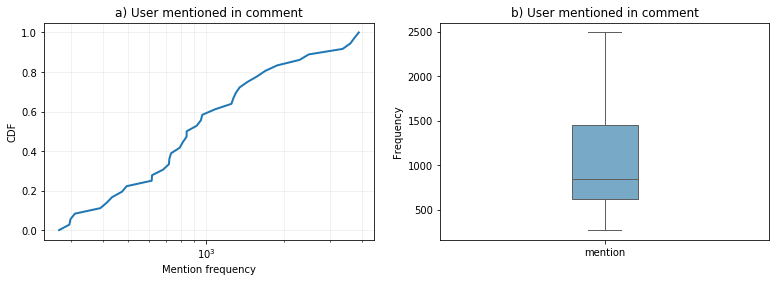

In [24]:
def plot_7():
    
    #fig = plt.figure(figsize=(6,4))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    
    analyzes = instagram_col_analyse.find({ "shortcode_username" : USER_ACCOUNT })
    
    reply_list = []
    for analyze in analyzes:
        reply_list.append(analyze['total_amount_of_replies'])

    data =  pd.DataFrame(reply_list)
    data.columns = ['mention']
    ser = data[['mention']].copy()
    ser = ser.sort_values(by='mention')
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser)
    ser_cdf.index.name = "Mention frequency"    
    ax5 = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1)
    ax5.grid(True, which='both', linestyle='-', alpha=0.2)
    ax5.set_ylabel("CDF")
    ax5.set_title("a) User mentioned in comment")
    
    
# #     boxplot = data.boxplot(ax=ax2, showfliers=False)
    
    boxplot2 = sns.boxplot( data=data, showfliers=False, palette="Blues", linewidth=1, width=0.2, ax=ax2)
#     boxplot2.set_xlabel("Mention")
    boxplot2.set_ylabel("Frequency")
    boxplot2.set_title("b) User mentioned in comment")

plot_7()

In [25]:
# import instaloader
# L = instaloader.Instaloader()
# L.login('baham_begardimm', '1123581321')
# profile = instaloader.Profile.from_username(L.context, USER_ACCOUNT)
# print("{} follows these profiles:".format(profile.username))
# for follower in profile.get_followers():
#     print(follower.username)

In [26]:
def percentage(percent, whole):
    return (percent * whole) / 100.0

def percentage_part(part, whole):
    return 100 * float(part)/float(whole)

 Total User: 59467
 G1 popularity: 0.05% | 27
 G2 popularity: 0.09% | 52
 G3 popularity: 0.50% | 300
 G4 popularity: 99.36% | 59088


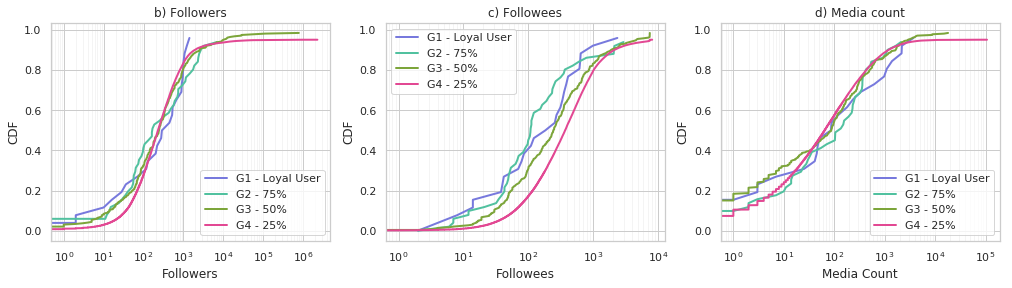

In [27]:
def plot_8():
    list_of_unique_user_id_per_comment = list(instagram_col_comment.aggregate([

        { '$match':
         { 
             '$and': [
#                  { 'user_crawled': True }, 
#                  { 'user_not_exists': None },
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        {'$group':   {
            "_id": "$owener_id",
            "totalComment" : {"$sum" : 1},
            "post_ids" : {"$addToSet" : "$post_shortcode"},
            "post_texts": {"$addToSet" : "$text"},
            'owener_followers' : { '$first': '$owener_followers' },
            'owener_followees' : { '$first': '$owener_followees' },
            'owener_mediacount' : { '$first': '$owener_mediacount' },
            'owener_biography' : { '$first': '$owener_biography' },
            'owener_username' : { '$first': '$owener_username' },
            }
        },

    ]))

#     data =  pd.DataFrame(list_of_unique_user_id_per_comment)
#     print(data)

    data =  pd.DataFrame(list_of_unique_user_id_per_comment)
    total_users = data.shape[0]
    print( " Total User: " + str(total_users))
    data['Total_post'] = data['post_ids'].str.len()

    df = data[['_id', 'owener_username', 'totalComment', 'Total_post', 'owener_followers', 'owener_followees', 'owener_mediacount']]

    grouped = df.groupby('Total_post')

    list_keys = list(grouped.groups.keys())

    df_grouped = pd.DataFrame({'count' : grouped.size()}).reset_index()
    df_grouped['Group'] = "G1"
    
    
    fig2, (ax4) = plt.subplots(1,1, figsize=(17,4))
    sns.set(style="whitegrid")
    
    
    percent_75 = percentage(75, list_keys[-1])
    percent_50 = percentage(50, list_keys[-1])
    percent_25 = percentage(25, list_keys[-1])
    
    G1_color = '#7779dd'
    G2_color = '#51c19f'
    G3_color = '#7ca53a'
    G4_color= '#e24893'
    
    
    df_grouped.loc[df_grouped['Total_post'] > percent_75, ['Group']] = "G1 - Loyal User"
    df_grouped.loc[ (df_grouped['Total_post'] > percent_50) & (df_grouped['Total_post'] <= percent_75), ['Group']] = "G2 - 75%"
    df_grouped.loc[ (df_grouped['Total_post'] > percent_25) & (df_grouped['Total_post'] <= percent_50), ['Group']] = "G3 - 50%"
    df_grouped.loc[df_grouped['Total_post'] <= percent_25, ['Group']] = "G4 - 25%"
    

#     print(df_grouped)

    ax = sns.barplot(x="Total_post", y="count", data=df_grouped, ax=ax4, ci="sd", hue="Group", dodge=False, palette=[ G4_color, G3_color, G2_color, G1_color])
    ax.set_yscale('log')
    ax.set_title("a) User accounts grouped by total number of comments")
    ax.set_xlabel("Total Comment")
    ax.set_ylabel("User Count")
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,4))
    
    # ========= Group 1 - 100% =========
    list_100 = [x for x in list_keys if x > percent_75]
    l_tmp = []
    for i in list_100:
        l_tmp.append(list_keys.index(i))
    
    df_100 = pd.DataFrame()
    
    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_100 = pd.concat([df_100, df_tmp])
        
    g1_popularity = (100 * df_100.shape[0] ) / (total_users)
    print( " G1 popularity: " + "{:,.2f}".format(g1_popularity) + "% | " + str(df_100.shape[0]))

    df_100.replace("", np.nan, inplace=True)
    
    #df_latest = pd.DataFrame(grouped.get_group(list_keys[-1]))

    if (not df_100.empty):
        # followers  
        ser = df_100[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ser_cdf.index.name = "Followers"    
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G1 - Loyal User', color=G1_color)
        ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
        ax.set_ylabel("CDF")
        ax.set_title('b) Followers')

        # followees 
        ser = df_100[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ser_cdf.index.name = "Followees"    
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G1 - Loyal User', color=G1_color)
        ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
        ax.set_ylabel("CDF")
        ax.set_title("c) Followees")

        # media count
        ser = df_100[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ser_cdf.index.name = "Media Count"    
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G1 - Loyal User', color=G1_color)
        ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
        ax.set_ylabel("CDF")
        ax.set_title("d) Media count")
    
    
    
    # ========= Group 2 - 75% =========   
    list_75 = [x for x in list_keys if x > percent_50 and x <= percent_75]
    l_tmp = []
    for i in list_75:
        l_tmp.append(list_keys.index(i))
        
    df_75 = pd.DataFrame()
    
    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_75 = pd.concat([df_75, df_tmp])
        
    g2_popularity = (100 * df_75.shape[0] ) / (total_users)
    print( " G2 popularity: " + "{:,.2f}".format(g2_popularity) + "% | " + str(df_75.shape[0]))

    df_75.replace("", np.nan, inplace=True)

    if (not df_75.empty):
        # followers  
        ser = df_75[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser) 
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G2 - 75%', color=G2_color)

        # followees
        ser = df_75[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G2 - 75%', color=G2_color)

        # media count
        ser = df_75[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)   
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G2 - 75%', color=G2_color)
    
    
    
    # ========= Group 3 - 50% =========
    list_50 = [x for x in list_keys if x > percent_25 and x <= percent_50]
    l_tmp = []
    for i in list_50:
        l_tmp.append(list_keys.index(i))
    df_50 = pd.DataFrame()
    
    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_50 = pd.concat([df_50, df_tmp])
        
    g3_popularity = (100 * df_50.shape[0] ) / (total_users)
    print( " G3 popularity: " + "{:,.2f}".format(g3_popularity) + "% | " + str(df_50.shape[0]))

    df_50.replace("", np.nan, inplace=True)

    if (not df_50.empty):
        # followers  
        ser = df_50[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser) 
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G3 - 50%', color=G3_color)

        # followees
        ser = df_50[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G3 - 50%', color=G3_color)

        # media count
        ser = df_50[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)   
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G3 - 50%', color=G3_color)
    
    
    # ========= Group 4 - 25% =========
    list_25 = [x for x in list_keys if x <= percent_25]
    l_tmp = []
    for i in list_25:
        l_tmp.append(list_keys.index(i))
    df_25 = pd.DataFrame()

    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_25 = pd.concat([df_25, df_tmp])
        
    g4_popularity = (100 * df_25.shape[0] ) / (total_users)
    print( " G4 popularity: " + "{:,.2f}".format(g4_popularity) + "% | " + str(df_25.shape[0]))

    df_25.replace("", np.nan, inplace=True)

    if (not df_25.empty):
        # followers  
        ser = df_25[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser) 
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G4 - 25%', color=G4_color)

        # followees
        ser = df_25[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G4 - 25%', color=G4_color)

        # media count
        ser = df_25[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)   
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G4 - 25%', color=G4_color)
    
plot_8()

In the next step, as it can be seen in figure a) we divided users into 4 clusters in the term of posting comment, G1 Loyal Users, which have commented in nearly all of the posts, G2 Group that are participated in 75% of the posts, G3 and G4 that have been posting comments up to 50% and 25% of the total posts respectively.

Figure b) represents the empirical distribution of "Follower" feature of the user account. Also, figure c) and d) demonstrate the CDF plot of them on different features, "Followee" and "Media Count" respectively. With regard to all 3 profile features, while groups G1 to G3 are following the same pattern, G4 shows a different attitude.

In [28]:
def plot_9():
    list_of_unique_user_id_per_comment = list(instagram_col_like.aggregate(pipeline=[
        
        { '$match':
         { 
             '$and': [
#                  { 'user_crawled': True }, 
#                  { 'user_not_exists': None },
                 { 'shortcode_username': USER_ACCOUNT },
             ]
         }
        },

        {'$group':   {
            "_id": "$owener_id",
            "totalComment" : {"$sum" : 1},
            "post_ids" : {"$addToSet" : "$post_shortcode"},
            "post_texts": {"$addToSet" : "$text"},
            'owener_followers' : { '$first': '$owener_followers' },
            'owener_followees' : { '$first': '$owener_followees' },
            'owener_mediacount' : { '$first': '$owener_mediacount' },
            'owener_biography' : { '$first': '$owener_biography' },
            'owener_username' : { '$first': '$owener_username' },
            }
        },

    ],
        allowDiskUse=True
    ))


    data =  pd.DataFrame(list_of_unique_user_id_per_comment)
    total_users = data.shape[0]
    print( " Total User: " + str(total_users))
    data['Total_post'] = data['post_ids'].str.len()

    df = data[['_id', 'owener_username', 'totalComment', 'Total_post', 'owener_followers', 'owener_followees', 'owener_mediacount']]

    grouped = df.groupby('Total_post')

    list_keys = list(grouped.groups.keys())

    df_grouped = pd.DataFrame({'count' : grouped.size()}).reset_index()
    df_grouped['Group'] = "G1"
    
    
    fig2, (ax4) = plt.subplots(1,1, figsize=(17,4))
    sns.set(style="whitegrid") 
    
    
    percent_75 = percentage(75, list_keys[-1])
    percent_50 = percentage(50, list_keys[-1])
    percent_25 = percentage(25, list_keys[-1])
    
    G1_color = '#7779dd'
    G2_color = '#51c19f'
    G3_color = '#7ca53a'
    G4_color= '#e24893'
    
    
    df_grouped.loc[df_grouped['Total_post'] > percent_75, ['Group']] = "G1 - Loyal User"
    df_grouped.loc[ (df_grouped['Total_post'] > percent_50) & (df_grouped['Total_post'] <= percent_75), ['Group']] = "G2 - 75%"
    df_grouped.loc[ (df_grouped['Total_post'] > percent_25) & (df_grouped['Total_post'] <= percent_50), ['Group']] = "G3 - 50%"
    df_grouped.loc[df_grouped['Total_post'] <= percent_25, ['Group']] = "G4 - 25%"
    

#     print(df_grouped)

    ax = sns.barplot(x="Total_post", y="count", data=df_grouped, ax=ax4, ci="sd", hue="Group", dodge=False, palette=[ G4_color, G3_color, G2_color, G1_color])
    ax.set_yscale('log')
    ax.set_title("a) User accounts grouped by total number of likes")
    ax.set_xlabel("Total Likes")
    ax.set_ylabel("User Count")
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,4))
    
    # ========= Group 1 - 100% =========
    list_100 = [x for x in list_keys if x > percent_75]
    l_tmp = []
    for i in list_100:
        l_tmp.append(list_keys.index(i))
    
    df_100 = pd.DataFrame()
    
    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_100 = pd.concat([df_100, df_tmp])
        
    g1_popularity = (100 * df_100.shape[0] ) / (total_users)
    print( " G1 popularity: " + "{:,.2f}".format(g1_popularity) + "% | " + str(df_100.shape[0]))

    df_100.replace("", np.nan, inplace=True)
    
    #df_latest = pd.DataFrame(grouped.get_group(list_keys[-1]))

    if (not df_100.empty):
        # followers  
        ser = df_100[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ser_cdf.index.name = "Followers"    
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G1 - Loyal User', color=G1_color)
        ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
        ax.set_ylabel("CDF")
        ax.set_title('b) Followers')

        # followees 
        ser = df_100[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ser_cdf.index.name = "Followees"    
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G1 - Loyal User', color=G1_color)
        ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
        ax.set_ylabel("CDF")
        ax.set_title("c) Followees")

        # media count
        ser = df_100[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ser_cdf.index.name = "Media Count"    
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G1 - Loyal User', color=G1_color)
        ax.xaxis.grid(True, which='minor', linestyle='-', alpha=0.2)
        ax.set_ylabel("CDF")
        ax.set_title("d) Media count")
    
    
    
    # ========= Group 2 - 75% =========   
    list_75 = [x for x in list_keys if x > percent_50 and x <= percent_75]
    l_tmp = []
    for i in list_75:
        l_tmp.append(list_keys.index(i))
        
    df_75 = pd.DataFrame()
    
    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_75 = pd.concat([df_75, df_tmp])
        
    g2_popularity = (100 * df_75.shape[0] ) / (total_users)
    print( " G2 popularity: " + "{:,.2f}".format(g2_popularity) + "% | " + str(df_75.shape[0]))

    df_75.replace("", np.nan, inplace=True)

    if (not df_75.empty):
        # followers  
        ser = df_75[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser) 
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G2 - 75%', color=G2_color)

        # followees
        ser = df_75[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G2 - 75%', color=G2_color)

        # media count
        ser = df_75[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)   
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G2 - 75%', color=G2_color)
    
    
    
    # ========= Group 3 - 50% =========
    list_50 = [x for x in list_keys if x > percent_25 and x <= percent_50]
    l_tmp = []
    for i in list_50:
        l_tmp.append(list_keys.index(i))
    df_50 = pd.DataFrame()
    
    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_50 = pd.concat([df_50, df_tmp])
        
    g3_popularity = (100 * df_50.shape[0] ) / (total_users)
    print( " G3 popularity: " + "{:,.2f}".format(g3_popularity) + "% | " + str(df_50.shape[0]))

    df_50.replace("", np.nan, inplace=True)

    if (not df_50.empty):
        # followers  
        ser = df_50[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser) 
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G3 - 50%', color=G3_color)

        # followees
        ser = df_50[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G3 - 50%', color=G3_color)

        # media count
        ser = df_50[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)   
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G3 - 50%', color=G3_color)
    
    
    # ========= Group 4 - 25% =========
    list_25 = [x for x in list_keys if x <= percent_25]
    l_tmp = []
    for i in list_25:
        l_tmp.append(list_keys.index(i))
    df_25 = pd.DataFrame()

    for item in l_tmp:
        df_tmp = pd.DataFrame(grouped.get_group(list_keys[item]))
        df_25 = pd.concat([df_25, df_tmp])
        
    g4_popularity = (100 * df_25.shape[0] ) / (total_users)
    print( " G4 popularity: " + "{:,.2f}".format(g4_popularity) + "% | " + str(df_25.shape[0]))

    df_25.replace("", np.nan, inplace=True)

    if (not df_25.empty):
        # followers  
        ser = df_25[['owener_followers']].copy()
        ser = ser.sort_values(by='owener_followers')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax1, legend=True, label='G4 - 25%', color=G4_color)

        # followees
        ser = df_25[['owener_followees']].copy()
        ser = ser.sort_values(by='owener_followees')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax2, legend=True, label='G4 - 25%', color=G4_color)

        # media count
        ser = df_25[['owener_mediacount']].copy()
        ser = ser.sort_values(by='owener_mediacount')
        ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser)   
        ax = ser_cdf.plot(logx=True, grid=True, linewidth=2, ax=ax3, legend=True, label='G4 - 25%', color=G4_color)
    
plot_9()

 Total User: 1101889
 G1 popularity: 0.09% | 963
 G2 popularity: 1.75% | 19243
 G3 popularity: 5.09% | 56081
 G4 popularity: 93.08% | 1025602


Figure a) demonstrates the 4 mentioned group (G1 to G4) with regards to the number of posts they have liked. It is obvious that the general trend is downward and there are few users who are engaged in more than 75% of the posts in our dataset. G4 has the highest number of likes and more than 1M users are categorized in this group. In contrast, G4 - Loyal User, has the least number of accounts but it contains valuable hidden information for us.

Figure b) to c) show CDF plot of 3 main profile feature of these users including Follower, Followee and Media Count. The most notable thing is that "G1 - Loyal User" trend is totally different from three others. Also in this study, as the G1 group has participated in nearly all posts, is of high interest for the evaluation.